In [ ]:
"""
Purpose: Networks Homework 2

"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os import sys
sys.path.append("/python_tools/python_tools/")
sys.path.append("/graph_tools/graph_tools/")

In [3]:
#generic python modules
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# modules from python tools
import matlab_utils as matu
import numpy_utils as nu
import networkx_utils as xu

In [6]:
# modules from graph_tools
import graph_statistics as gs

# Problem 2.1: Classification of Cancer Types

In [7]:
"""
Purpose: To be able to distinguish patients with different
ovarian cancers (labels) using graph fourier analysis 
and treating the genetic vectors of each patient as the graph
signal over the graph of the genetic interaction network
"""

'\nPurpose: To be able to distinguish patients with different\novarian cancers (labels) using graph fourier analysis \nand treating the genetic vectors of each patient as the graph\nsignal over the graph of the genetic interaction network\n'

## Prep: Loading Data

In [8]:
"""
Data background: 

1) geneNetwork_rawPCNCI
Adjacency matrix of 2458 genes
-> edge exists if 2 genes encode protein that participate
in the same metabolic reaction

2) signal_mutation
Array where each row notes if patient has a mutation in the 
gene or not
- Key: 1 -> mutation, 0 -> no mutation

3) histology_subtype:
Column vector that gives the phenotype classification of each patient
key: 1--> serous subtype ovarian cancer, 2--> endometroid subtype ovariance cancer
"""

'\nData background: \n\n1) geneNetwork_rawPCNCI\nAdjacency matrix of 2458 genes\n-> edge exists if 2 genes encode protein that participate\nin the same metabolic reaction\n\n2) signal_mutation\nArray where each row notes if patient has a mutation in the \ngene or not\n- Key: 1 -> mutation, 0 -> no mutation\n\n3) histology_subtype:\nColumn vector that gives the phenotype classification of each patient\nkey: 1--> serous subtype ovarian cancer, 2--> endometroid subtype ovariance cancer\n'

# ! Note: The adjacency matrix had self loops so those were removed !

In [9]:
filepath_adj = "./Data/genetics/geneNetwork_rawPCNCI.mat"
gene_adj_pre = matu.loadmat(filepath_adj)["geneNetwork_rawPCNCI"].astype('float')
gene_adj = gene_adj_pre- nu.diagonal_matrix_from_array(gene_adj_pre)
gene_adj

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
genetic_prof_filepath = "./Data/genetics/signal_mutation.mat"
genetic_prof = matu.loadmat(genetic_prof_filepath)["signal_mutation"].astype('int')
genetic_prof

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [11]:
genetic_prof.shape,np.max(genetic_prof),np.min(genetic_prof)

((240, 2458), 1, 0)

In [12]:
phenotype_filepath = "./Data/genetics/histology_subtype.mat"
classes = matu.loadmat(phenotype_filepath)["histology_subtype"].astype('int').ravel()
classes

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1])

(array([ 44.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 196.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

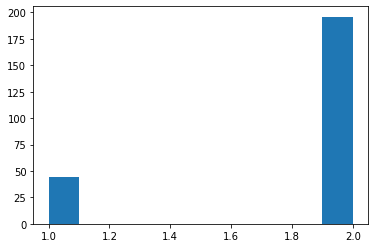

In [13]:
plt.hist(classes)

In [14]:
class_1_mask = classes == 1
class_2_mask = classes == 2

## a) Distinguishing Power

In [15]:
"""
Purpose: Find which frequency of the genetics graph that 
has the greated distinguishing power for the genetic graph signals
of the patients of the 2 subclasses

Pseudocode: 
0) Compute the Laplacian from the adjacency matrix
1) Compute the eigenvalues and eigenvectors of the genetics graph Laplacian
2) Compute the GFT of the observations using the eigenvectors

3) For each eigenvector (or can do this with matrix operations): 
a) Compute the distinguishing power by
    i) mean GFT coefficient of class 1
    ii) mean GFT coefficient of class 2
    iii) Find the difference of mean GFT
    iv) Divide by the sum of all GFT coefficients

4) Plot the DP vs eigenvector index
5) Plot a boxplot of all the DP
"""

'\nPurpose: Find which frequency of the genetics graph that \nhas the greated distinguishing power for the genetic graph signals\nof the patients of the 2 subclasses\n\nPseudocode: \n0) Compute the Laplacian from the adjacency matrix\n1) Compute the eigenvalues and eigenvectors of the genetics graph Laplacian\n2) Compute the GFT of the observations using the eigenvectors\n\n3) For each eigenvector (or can do this with matrix operations): \na) Compute the distinguishing power by\n    i) mean GFT coefficient of class 1\n    ii) mean GFT coefficient of class 2\n    iii) Find the difference of mean GFT\n    iv) Divide by the sum of all GFT coefficients\n\n4) Plot the DP vs eigenvector index\n5) Plot a boxplot of all the DP\n'

In [16]:
# testing if the graph adjacency matrix is symmetric
print(f"Is the adjacency matrix symmetric? {nu.check_symmetric(gene_adj)}")

Is the adjacency matrix symmetric? True


In [17]:
#0) Compute the Laplacian from the adjacency matrix
L = xu.laplacian_from_adj(gene_adj.astype('float'))
L.shape

(2458, 2458)

In [18]:
#1) Compute the eigenvalues and eigenvectors of the genetics graph Laplacian
eigvals, eigvecs = nu.eig_vals_vecs(L)

In [19]:
#2) Compute the GFT of the observations using the eigenvectors
gft_coeff = ((eigvecs.T)@genetic_prof.T)
gft_coeff.shape

(2458, 240)

In [20]:
# 3) Compute the distingushing power (dp)
dp = np.abs(
    gft_coeff[:,class_1_mask].mean(axis=1) 
    - gft_coeff[:,class_2_mask].mean(axis=1)
)/np.sum(np.abs(gft_coeff),axis=1)

dp.shape

(2458,)

In [21]:
# 3b) check dp calculation correct
k = 24
gft_coeff_k = gft_coeff[k]
dp_k = np.abs(
    np.sum(gft_coeff_k[class_1_mask])/np.sum(class_1_mask)
    - np.sum(gft_coeff_k[class_2_mask])/np.sum(class_2_mask)
)/np.sum(np.abs(gft_coeff_k))

print(f"for k = {k}: dp from matrix = {dp[k]}, dp_k computed individually = {dp_k}")

for k = 24: dp from matrix = 0.004979453144072854, dp_k computed individually = 0.004979453144072857


Text(0, 0.5, 'Distinguishing Power (DP)')

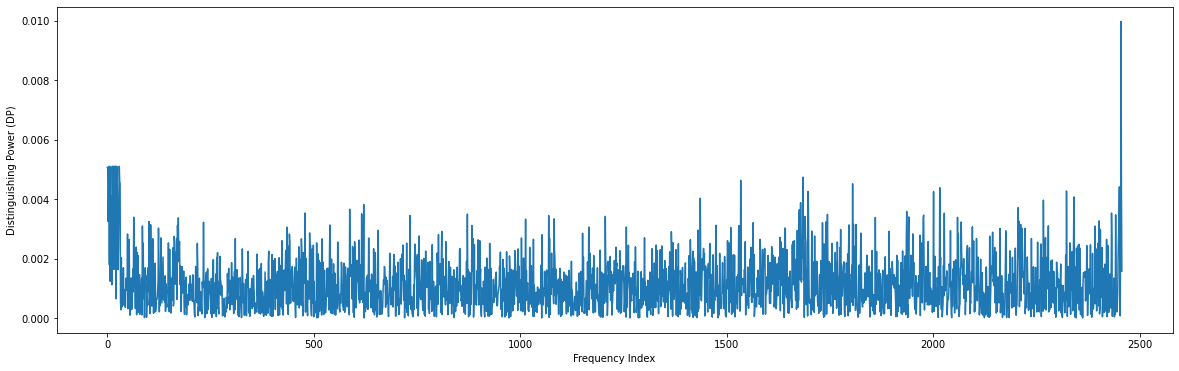

In [22]:
# 4) Plot the DP vs eigenvector index
figsize = (20,6)

fig,ax = plt.subplots(1,1,figsize=figsize)
ax.plot(np.arange(len(dp)),dp)
ax.set_xlabel("Frequency Index")
ax.set_ylabel("Distinguishing Power (DP)")

In [23]:
dp_max_k = np.argmax(dp)
print(f"Largest dp frequency index = {dp_max_k}")

Largest dp frequency index = 2455


Text(0, 0.5, 'Distinguishing Power (DP)')

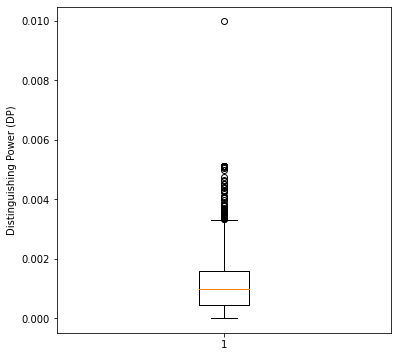

In [24]:
#5) Plot a boxplot of all the DP
figsize = (6,6)

fig,ax = plt.subplots(1,1,figsize=figsize)
ax.boxplot(dp)
ax.set_ylabel("Distinguishing Power (DP)")

## b) k-NN classification

In [25]:
"""
Purpose: Implemnet a k-NN classifier and report the accuracies for
different hyper-parameters of k

Pseudocode: 
1) Compute the pairwise Euclidean distance between all observations
(using the original vectors and not the GFT coefficients)

2) for K in possible k hyperparameters
a) Predicted Label: Compute the majority label for the k closest neighbors of all datapoint
b) Compute accuracy based on ground truth label vs predicted

3) Plot the accuracies as a function of k 
"""

'\nPurpose: Implemnet a k-NN classifier and report the accuracies for\ndifferent hyper-parameters of k\n\nPseudocode: \n1) Compute the pairwise Euclidean distance between all observations\n(using the original vectors and not the GFT coefficients)\n\n2) for K in possible k hyperparameters\na) Predicted Label: Compute the majority label for the k closest neighbors of all datapoint\nb) Compute accuracy based on ground truth label vs predicted\n\n3) Plot the accuracies as a function of k \n'

In [26]:
def knn_classification(
    embeddings,
    labels,
    k_range = (3,5,7),
    plot = True,
    ):

    #1) Compute the pairwise Euclidean distance between all observations
    dist_matrix = nu.distance_matrix(
        embeddings,embeddings,
        verbose = True,
    )

    #setting the diagonal to inf to prevent self from being in closest neighbors
    dist_matrix = dist_matrix + np.diag([np.inf]*len(dist_matrix))
    
    accuracy_dict = dict()

    for k in k_range:
        k_nearest_neighbors = np.argsort(dist_matrix,axis=1)[:,:k]
        k_nearest_classes = classes[k_nearest_neighbors]
        predicted_classes = nu.mode(k_nearest_classes,axis = 1)
        accuracy = np.sum(classes == predicted_classes)/len(classes)*100
        accuracy_dict[k] = np.round(accuracy,5)

    if plot: 
        fig,ax = plt.subplots(1,1,figsize = (6,6))
        ax.bar(
            list(accuracy_dict.keys()),
            list(accuracy_dict.values()),
        )

        ax.set_xlabel("k")
        ax.set_ylabel("Accuracy (%)")
        ax.set_title("Histology Prediction Accuracy vs K")
        
    return accuracy_dict

Total time for distance matrix = 3.079927444458008


{3: 88.33333, 5: 88.33333, 7: 85.41667}

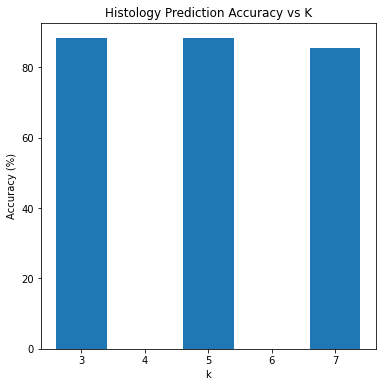

In [27]:
knn_classification(
    embeddings=genetic_prof,
    labels=classes,
    plot = True,
)

## c) Filtering almost al frequencies

In [28]:
"""
Purpose: Re-run the k-NN classification
but using the original graph signals after
passing through a bandpass filter only allowing 
the largest DP frequency

Pseudocode: 
1) Build function that converts DP ranking
or percentiles to the idx of the basic vectors
to keep in the filter

2) Compute the filtered graph signals by
y = U @ h(diag) @ U^T @ x
- h(x) zeros out all rows not in bandpass
- x: original graph sgnals

3) Run the kNN classification
"""

'\nPurpose: Re-run the k-NN classification\nbut using the original graph signals after\npassing through a bandpass filter only allowing \nthe largest DP frequency\n\nPseudocode: \n1) Build function that converts DP ranking\nor percentiles to the idx of the basic vectors\nto keep in the filter\n\n2) Compute the filtered graph signals by\ny = U @ h(diag) @ U^T @ x\n- h(x) zeros out all rows not in bandpass\n- x: original graph sgnals\n\n3) Run the kNN classification\n'

In [29]:
"""
1) Build function that converts DP ranking
or percentiles to the idx of the basic vectors
to keep in the filter
"""

def freq_idx_from_dp_criteria(
    dp_values,
    n_highest_dp = None,
    percentile_dp = None,
    return_mask = False,
    verbose = False,
    ):
    
    dp_values = np.array(dp_values)
    
    if n_highest_dp is not None:
        if verbose:
            print(f"Using n_highest_dp method ")
        return_idx = np.flip(np.argsort(dp_values))[:n_highest_dp]
    elif percentile_dp is not None:
        if verbose:
            print(f"Using percentile method ")
        perc_value = np.percentile(dp_values,percentile_dp)
        if verbose:
            print(f"{percentile_dp}th percentile value = {perc_value}")
        return_idx = np.where(dp_values >= perc_value)[0]
        return_idx = return_idx[np.flip(np.argsort(dp_values[return_idx]))]
    else:
        raise Exception("")
        
    if return_mask:
        if verbose:
            print(f"Returning mask")
        return_mask = np.zeros(len(dp_values)).astype('bool')
        return_mask[return_idx] = True
        return return_mask
    else:
        return return_idx
    
freq_idx_from_dp_criteria(
    dp,
    n_highest_dp = 10,
    verbose = True, 
)

freq_idx_from_dp_criteria(
    dp,
    percentile_dp = 95,
    verbose = True, 
)

Using n_highest_dp method 
Using percentile method 
95th percentile value = 0.0027634102011862604


array([2455,   17,   20,    6,   23,   14,   12,   19,   29,    4,    0,
          1,   24, 1685, 1534,   30,   31, 1805, 2451, 2016, 2456, 2323,
       1697, 2001,   10, 2341, 1436, 2267, 1679,  621,   28,    3, 2206,
        587,   15, 1676,   13,    9, 1698, 1936,  479, 2432, 2027,  616,
        872, 1744, 1675, 2442, 1977, 1069,  733, 1206, 1690, 1941,   64,
       2059, 1860,  172, 1976, 1082, 1013, 2450,   25, 2402, 2208,  101,
          2, 1740,   22, 2068,  233, 1564, 1732, 1813, 1807, 2212,  105,
       1796,  539, 1474,  170,  883, 1530, 2279,   85, 2392, 2095, 1257,
       1166,  435, 1510, 1641,  124, 2222, 2215, 1642, 2162, 2405, 1776,
       1529,    8, 1431,  656, 1671, 2042, 2176, 1706, 1893,  810, 1366,
       2144, 1673,  490, 1825, 1151, 1951,   49,  441, 2061,  802, 1053,
       2211, 1968])

### -- graph fourier transform filter ---

In [58]:
def graph_signals_filter(
    x,
    U,
    eigvals,
    # for determining the frequencies to keep
    freq_keep_idx = None,
    dp = None,
    n_highest_dp = None,
    percentile_dp = None,
    
    verbose = False,
    ):
    """
    Purpose: to compute the 
    graph signals after passing through a 
    graph fourier transform
    """
    
    if freq_keep_idx is None:
        freq_keep_idx = freq_idx_from_dp_criteria(
            dp,
            n_highest_dp = n_highest_dp,
            percentile_dp=percentile_dp,
            verbose = verbose, 
            return_mask = False
        )
        
    if verbose:
        print(f"freq_keep_idx = {freq_keep_idx}")
        
    
    
    freq_keep_mask = np.zeros((len(U))).astype('bool')
    
    #print(f"# of non_zero values freq_keep_mask = {np.sum(freq_keep_mask == True)}")
    freq_keep_mask[freq_keep_idx] = True
    #print(f"# of non_zero values freq_keep_mask = {np.sum(freq_keep_mask == True)}")
    
    
    # computing the graph fourier polynomial of the diagonal matrix
    eig_values_filt = eigvals.copy()
    eig_values_filt[~freq_keep_mask] = 0
    DM = np.diag(eig_values_filt)
    
    if verbose:
        print(f"# of non_zero values = {np.sum(eig_values_filt > 0.0001)}")
        print(f"# of non zero DM values = {np.sum(DM.ravel() > 0.0001)}")

    y_dp_max = U@DM@(U.T)@x
    return y_dp_max

Using n_highest_dp method 
freq_keep_idx = [2455]
# of non_zero values = 1
# of non zero DM values = 1
Total time for distance matrix = 0.5228261947631836


{3: 90.0, 5: 88.75, 7: 89.16667}

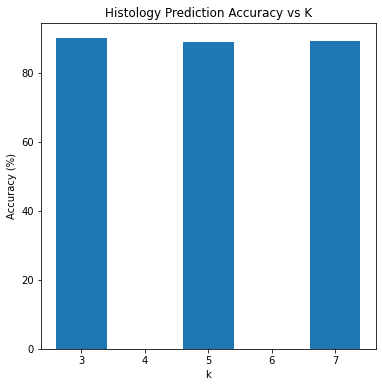

In [59]:
y_dp_max = graph_signals_filter(
    x = genetic_prof.T,
    U = eigvecs,
    eigvals = eigvals,
    
    dp = dp,
    n_highest_dp=1,
    
    verbose = True,
)

knn_accuracy = knn_classification(
    embeddings=y_dp_max.T,
    labels=classes,
    plot = True,
)

knn_accuracy

## d) Filtering Most Frequencies

In [60]:
perc_range = [75,80,85,90,95]
plot = False

all_results = []
for perc in perc_range:
    y_dp_perc = graph_signals_filter(
        x = genetic_prof.T,
        U = eigvecs,
        eigvals = eigvals,

        dp = dp,
        percentile_dp=perc,

        verbose = True,
    )

    knn_accuracy = knn_classification(
        embeddings=y_dp_perc.T,
        labels=classes,
        plot = plot,
    )
    
    all_results += [dict(percentile = perc,k = k, accuracy = v) for k,v in 
                   knn_accuracy.items()]
    
all_results

Using percentile method 
75th percentile value = 0.0015960241065402702
freq_keep_idx = [2455   17   20    6   23   14   12   19   29    4    0    1   24 1685
 1534   30   31 1805 2451 2016 2456 2323 1697 2001   10 2341 1436 2267
 1679  621   28    3 2206  587   15 1676   13    9 1698 1936  479 2432
 2027  616  872 1744 1675 2442 1977 1069  733 1206 1690 1941   64 2059
 1860  172 1976 1082 1013 2450   25 2402 2208  101    2 1740   22 2068
  233 1564 1732 1813 1807 2212  105 1796  539 1474  170  883 1530 2279
   85 2392 2095 1257 1166  435 1510 1641  124 2222 2215 1642 2162 2405
 1776 1529    8 1431  656 1671 2042 2176 1706 1893  810 1366 2144 1673
  490 1825 1151 1951   49  441 2061  802 1053 2211 1968  755 2205 1713
 2137  162 2449 1629 2272 1301  130 1691 1003  633 1071 1684  168 2238
 2105  310  886  110  520  470 1032 1581 2420   53 1412  898  610  423
  902 1664 1502 2098 1682 1661   18 1988  820 1631 1545  599  175 2433
  442 1663 1935 1768  558 2454 2253  163 2340 1692 1505 1370 

Total time for distance matrix = 0.5083262920379639
Using percentile method 
95th percentile value = 0.0027634102011862604
freq_keep_idx = [2455   17   20    6   23   14   12   19   29    4    0    1   24 1685
 1534   30   31 1805 2451 2016 2456 2323 1697 2001   10 2341 1436 2267
 1679  621   28    3 2206  587   15 1676   13    9 1698 1936  479 2432
 2027  616  872 1744 1675 2442 1977 1069  733 1206 1690 1941   64 2059
 1860  172 1976 1082 1013 2450   25 2402 2208  101    2 1740   22 2068
  233 1564 1732 1813 1807 2212  105 1796  539 1474  170  883 1530 2279
   85 2392 2095 1257 1166  435 1510 1641  124 2222 2215 1642 2162 2405
 1776 1529    8 1431  656 1671 2042 2176 1706 1893  810 1366 2144 1673
  490 1825 1151 1951   49  441 2061  802 1053 2211 1968]
# of non_zero values = 99
# of non zero DM values = 99
Total time for distance matrix = 0.9988455772399902


[{'percentile': 75, 'k': 3, 'accuracy': 86.66667},
 {'percentile': 75, 'k': 5, 'accuracy': 89.58333},
 {'percentile': 75, 'k': 7, 'accuracy': 90.83333},
 {'percentile': 80, 'k': 3, 'accuracy': 86.25},
 {'percentile': 80, 'k': 5, 'accuracy': 89.16667},
 {'percentile': 80, 'k': 7, 'accuracy': 90.83333},
 {'percentile': 85, 'k': 3, 'accuracy': 89.16667},
 {'percentile': 85, 'k': 5, 'accuracy': 89.58333},
 {'percentile': 85, 'k': 7, 'accuracy': 90.83333},
 {'percentile': 90, 'k': 3, 'accuracy': 90.0},
 {'percentile': 90, 'k': 5, 'accuracy': 89.58333},
 {'percentile': 90, 'k': 7, 'accuracy': 90.83333},
 {'percentile': 95, 'k': 3, 'accuracy': 90.41667},
 {'percentile': 95, 'k': 5, 'accuracy': 89.58333},
 {'percentile': 95, 'k': 7, 'accuracy': 90.83333}]

In [61]:
import pandas as pd
df = pd.DataFrame.from_records(all_results)
df

percentile  k  accuracy
0           75  3  86.66667
1           75  5  89.58333
2           75  7  90.83333
3           80  3  86.25000
4           80  5  89.16667
5           80  7  90.83333
6           85  3  89.16667
7           85  5  89.58333
8           85  7  90.83333
9           90  3  90.00000
10          90  5  89.58333
11          90  7  90.83333
12          95  3  90.41667
13          95  5  89.58333
14          95  7  90.83333

# Problem 2.2

In [73]:
import pandas_utils as pu
import networkx_utils as xu

## A) Construct a network from the flight data

In [69]:
nodes_filepath = "./Data/epidemics/airport_Nodes_GC.csv"
edges_filepath = "./Data/epidemics/airport_Edges_GC.csv"

In [68]:
nodes_df = pu.csv_to_df(nodes_filepath)
nodes_df

Id                        Name          City           Country  \
0        1                      Goroka        Goroka  Papua New Guinea   
1        2                      Madang        Madang  Papua New Guinea   
2        3                 Mount Hagen   Mount Hagen  Papua New Guinea   
3        4                      Nadzab        Nadzab  Papua New Guinea   
4        5  Port Moresby Jacksons Intl  Port Moresby  Papua New Guinea   
...    ...                         ...           ...               ...   
2900  7898    Huai An Lianshui Airport       Huai An             China   
2901  7932                       Gunsa     Shiquanhe             China   
2902  7933         Magdeburg-Cochstedt     Cochstedt           Germany   
2903  7946              Tureia Airport        Tureia  French Polynesia   
2904  7976              Ukunda Airport        Ukunda             Kenya   

     IATA/FAA  ICAO   Latitude   Longitude  Altitude  Timezone DST  \
0         GKA  AYGA  -6.081689  145.391881    5282.0      10.0   U   
1         MAG  AYMD  -5.207083  145.788700      20.0      10.0   U   
2         HGU  AYMH  -5.826789  144.295861    5388.0      10.0   U   
3         LAE  AYNZ  -6.569828  146.726242     239.0      10.0   U   
4         POM  AYPY  -9.443383  147.220050     146.0      10.0   U   
...       ...   ...        ...         ...       ...       ...  ..   
2900      HIA  ZSSH  33.777200  119.147800      23.0       8.0   N   
2901      NGQ  ZUAL  32.100270   80.052778   13780.0       8.0   N   
2902      CSO  EDBC  51.855833   11.418333     596.0       1.0   E   
2903      ZTA  NTGY -20.789700 -138.570000      12.0     -10.0   N   
2904      UKA  HKUK  -4.296940   39.571400       0.0       3.0   U   

      Component ID  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
2900             0  
2901             0  
2902             0  
2903             0  
2904             0  

[2905 rows x 12 columns]

In [70]:
edges_df = pu.csv_to_df(edges_filepath)
edges_df

Source  Target      Type  Weight
0           1       5  Directed     1.0
1           2       4  Directed     1.0
2           2       5  Directed     1.0
3           2       6  Directed     2.0
4           2    5430  Directed     1.0
...       ...     ...       ...     ...
30437    7933    1222  Directed     1.0
30438    7933    1230  Directed     1.0
30439    7946    1979  Directed     1.0
30440    7976    1145  Directed     2.0
30441    7976    1147  Directed     1.0

[30442 rows x 4 columns]

In [105]:
DiG = xu.edges_and_weights_to_graph(
    edges_list = edges_df[["Source","Target"]].to_numpy(),
    weights_list = edges_df["Weight"].to_numpy(),
    graph_type = "DiGraph"
    
)

print(f"Is graph DiGraph?: {xu.is_digraph(DiG)}")

#4) Add the node features to the graph
xu.set_node_attributes_from_df(
    DiG,
    nodes_df,
    index_name = "Id"
)

xu.print_node_edges_counts(DiG)

Is graph DiGraph?: True
 Graph: # of nodes = 2905, # of edges = 30442


### Converting the graph to an undirected graph

In [140]:
G = xu.undirected_sym_G_from_DiG(
    DiG,
    verbose = True,
)

Finished relabeling nodes
After symmmetric conversion to undirected graph
 Graph: # of nodes = 2905, # of edges = 15645


## B) Plot the Airport Network

In [153]:
import graph_statistics as gs
import matplotlib_utils as mu

In [141]:
"""
Purpose: To plot the network with the following characteristics
1) Node locations = (longitude,latitude)
2) Node size = eigenvector centrality (using the edge weights)
3) Controllable Transparency on Edges

Pseudocode: 
1) Export longitude and latitude of nodes
(from node_df)
2) Compute the eigenvector centrality of all
of the nodes (accounting for the edge weights)
3) Plot the graph using the: 
- node locations
- centralitys*scale as size
- edge color with alpha level
"""

'\nPurpose: To plot the network with the following characteristics\n1) Node locations = (longitude,latitude)\n2) Node size = eigenvector centrality (using the edge weights)\n3) Controllable Transparency on Edges\n\nPseudocode: \n1) Export longitude and latitude of nodes\n(from node_df)\n2) Compute the eigenvector centrality of all\nof the nodes (accounting for the edge weights)\n3) Plot the graph using the: \n- node locations\n- centralitys*scale as size\n- edge color with alpha level\n'

In [143]:
curr_node_df = xu.node_df(G)
node_ids = curr_node_df[xu.node_id_default].to_numpy()
node_pos = curr_node_df[["Latitude","Longitude"]].to_numpy()

In [152]:
eig_centrality = gs.eigenvector_centrality(
    G,
    weight = "weight"
)
eig_vec = np.array(list(eig_centrality.values()))
print(f"Norm of the eigenvector: {np.linalg.norm(eig_vec):.4f}")
print(f"Top eigenvector values: {np.flip(np.sort(eig_vec))[:3]}")

Norm of the eigenvector: 1.0000
Top eigenvector values: [0.17852923 0.16991023 0.16926958]


In [155]:
edge_color = "black"
alpha = 0.5
edge_color = mu.color_to_rgba(edge_color,alpha)
edge_color

array([0. , 0. , 0. , 0.5])

### plotting the map

In [157]:
import networkx as nx
nx.draw_networkx?

In [ ]:
nx.spring_layout(G)